ENGS 106 - Final Project
Authors - Taka Khoo, Doruk, Harry Leiter

<small>


             

    Overall design:

        typedef struct {
            image
            label
        } sample_t


        training(){
            init_network()
            sample = load_datapoint
            output = feedforward(sample->png)
            tocompare = getbackpropdata(sample)
            backprop(output, tocompare)
        }




        gettrainingdata(sample_t sample){
            Case (sample->label):
                1:
                    upscaledimg = upscale(sample->image)
                    gaussian = gaussian(upscaledimg)
                    harmonics = harmonics(gaussian, sample->fundamental_note_for_A_in_hertz)
                    harmonics_smear = gaussian(harmonics)
                    smooth = smooth(harmonics_smear)
                    return trainingcomparison       
                2:
                .
                .
                .
        
        }

        Still need to do init, feedforward, backprop pseudocode
</small>

# Below this markdown are an idea of the functions we could use to condition our data for the purposes of comparison during training

and here is my thinking behind these functions

<small> Create neural network Structure
    - inputs will be numbers 0-7 of mnist dataset (pictures of handwritten digits from 0-7)
        -These inputs will represent the notes of the major scale
    - output
        *Image of a spectrogram
            *Want to look like the input image? (maybe this would allow for more creative experimentation with finalized model than just looking like a letter)
            
            *Image is square, so we would want the output to be square as well
                -I'm not sure what to use for the image (spectrogram resolution):
                    Guessing around 1024x1024
                    
                    ~Training on 1024x1024 input images would probably be too resource intensive, so we might want to
                     upscale input image and then compare to that

                    *maybe drop down to 1008 for easier upscaling (mnist - 24x24 -- 24*36 = 1008 {24*4*3*3} -- esrgan upscaler works in factors of 1,2,3,4 )

            *We could compare the images with readily available tools online

            *In natural musical instruments, harmonics typically die out the further one gets from the fundamental note. Maybe we can
             achieve this by applying a horizontal gaussian filter to the output, and using that to determine loss as well
</small>

In [2]:



%pip install numpy
%pip install scipy
%pip install matplotlib
%pip install torch
%pip install torchaudio
%pip install torchvision
%pip install numpy
%pip install Pillow
%pip install opencv-python
%pip install scikit-image
%pip install git+https://github.com/pvigier/perlin-numpy


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/pvigier/perlin-numpy to /tmp/pip-req-build-pxmkj4_j
  Running command git clone --filter=blob:none --quiet https://github.com/pvigier/perlin-numpy /tmp/pip-req-build-pxmkj4_j
  Resolved https://github.com/pvigier/perlin-numpy to commit 5e26837db14042e51166eb6cad4c0df2c1907016
  Installing build dependencies ..

In [3]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter
from scipy.stats import norm
from PIL import Image
import matplotlib.pyplot as plt


* Upscaler:

In [4]:
def upscale(input):
    !cd Upscaler\
        && chmod u+x realesrgan-ncnn-vulkan\
        && ./realesrgan-ncnn-vulkan -i ../{input}.jpg -o ../{input}.png -s 3 > /dev/null 2>&1\
        && ./realesrgan-ncnn-vulkan -i ../{input}.png -o ../{input}.png -s 3 > /dev/null 2>&1\
        && ./realesrgan-ncnn-vulkan -i ../{input}.png -o ../{input}.png -s 4 > /dev/null 2>&1


* Gaussian function:

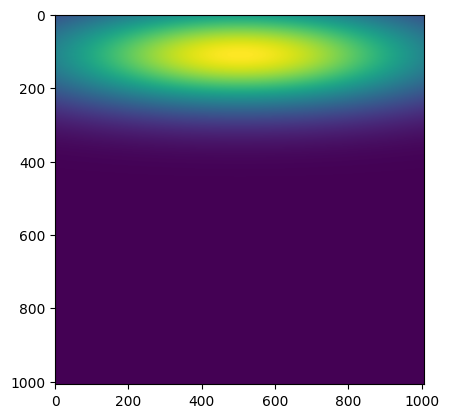

In [217]:
'''
                        1-D gaussian smearing
'''
def gaussian1d(image, sigma, axis):

    blurred = gaussian_filter1d(image, sigma=sigma, axis=axis)
    return blurred

'''
                        2-D gaussian smearing
'''
def gaussian2d(image, sigma):
    image = gaussian_filter(image, sigma = sigma)
    return image


'''
                        Applies gaussian filter across entire image
                            * Doesnt smear, multiplies input by the filter directly
'''


def gaussianfilter(image, sigma, mu, fade):
      
    for row in range(image.shape[1]):
        #get pdf values for the row, multiply them by img
        image[row, :] = norm(loc = mu, scale = sigma).pdf(row) * image[row, :]
    for col in range(image.shape[1]):
        image[:, col] = norm(loc = 504, scale = fade).pdf(col) * image[:, col]
    return image

test = np.full((1008, 1008), 255).astype(np.float64)
test = gaussianfilter(test, 100, 110, 400)
test= test / test.max()
plt.imshow(test)
plt.show()

* Frequency Selector:

In [199]:
'''
                            This function selects only desired frequencies base on fundamental note

                            We could also use this function to extract whatever frequencies we want to keep at whatever time
'''
def freq_selection(gaussian, fundamentalnote):
    only_selected = np.zeros((1008,1008))
    for column in range(1008):
        for row in range(1008):
            #Selection Conditions v
            if((row) % fundamentalnote == 0 or (row) % (1.25 * fundamentalnote)  == 0 or (row) % (1.5 * fundamentalnote) == 0 ):
                only_selected[row, column] = gaussian[row, column]
            else:
                only_selected[row, column] = 0

    return only_selected

* Perlin Noise:

6.084475911827321
255.0


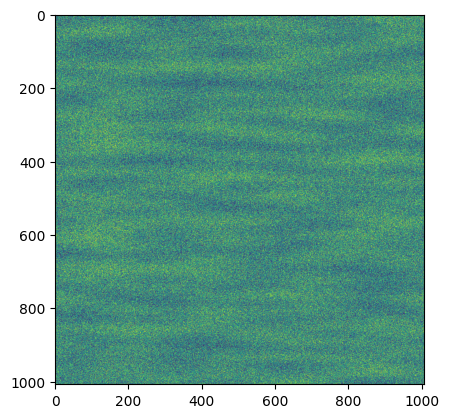

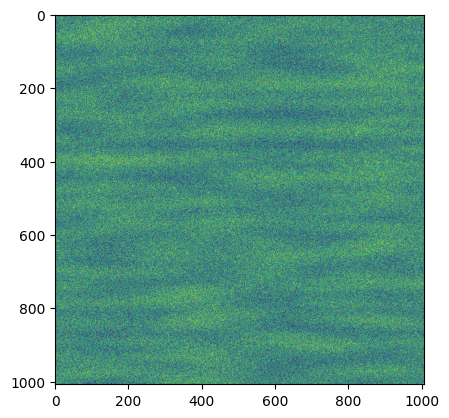

In [284]:
import matplotlib.pyplot as plt
import numpy as np
from perlin_numpy import (
    generate_perlin_noise_2d, generate_fractal_noise_2d
)


def perlin_2d(input, noisex, noisey, fuzz, dilution):
    noise = generate_perlin_noise_2d(input.shape, (noisey, noisex))

    offset = np.full((1008, 1008), dilution).astype(np.float64) + (np.random.rand(1008, 1008))*fuzz
    
    noise = noise + offset

    noise = noise / noise.max()    

    input = input * noise

    return input

def perlin_2d_filter(shape_, scale, noisex, noisey, fuzz, dilution):
    noise = generate_perlin_noise_2d(shape_.shape, (noisey, noisex))

    offset = np.full((1008, 1008), dilution).astype(np.float64) + (np.random.rand(1008, 1008))*fuzz
    
    noise = noise + offset

    noise = (noise / noise.max()) * scale

    return noise

test = np.full((1008, 1008), 255).astype(np.float64)
filter = perlin_2d_filter(test, 1, 4, 24, 7, 1)
test = perlin_2d(test, 4, 24, 7, 1)
print(test.min())
print(test.max())
plt.imshow(test)
plt.show()
plt.imshow(filter)
plt.show()

Convert Spectrogram to wav:

In [277]:
import numpy as np
import cv2
from scipy.io.wavfile import write
from scipy.signal import resample

def convert_to_wav(spectrogram, output, duration): 
    spectrogram = spectrogram.astype(np.float32)

    sample_rate = 44100
    numsample = int(sample_rate * duration)
    spectrogram = resample(spectrogram, numsample, axis = 1)
    print(spectrogram.shape)
    height, width = spectrogram.shape

    time = np.linspace(0, duration, width, endpoint=False)
    sinwaves = np.zeros((height, width)).astype(np.float32)

    #Looping over each row which is freq and each column which is time
    for row in range(height):
        offset = 0
        frequency = row + offset
        phase = np.abs(np.random.uniform(0, 2 * np.pi))
        amplitude_envelope = spectrogram[row, :]/255.0
        sinwaves[row, :] = amplitude_envelope * np.sin(2 * np.pi * frequency * time + phase)

    
    combined_signal = sinwaves.sum(axis = 0)


    resampled = resample(combined_signal, numsample)
    resampled /= np.max(np.abs(resampled))

    write(output, sample_rate, resampled.astype(np.float32))

In [ ]:
#ripped from geeksforgeeks

import cv2
from skimage.metrics import structural_similarity as ssim
# Function to calculate SSIM
def calculate_ssim(imageA, imageB):
    # Convert images to grayscale
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    
    # Compute SSIM between the two images
    score, _ = ssim(grayA, grayB, full=True)
    return score

imageA = cv2.imread('thenumber4-out.png')
imageB = cv2.imread('thenumber5-out.png')

ssim_score = calculate_ssim(imageA, imageB)
print(f"SSIM score: {ssim_score}")

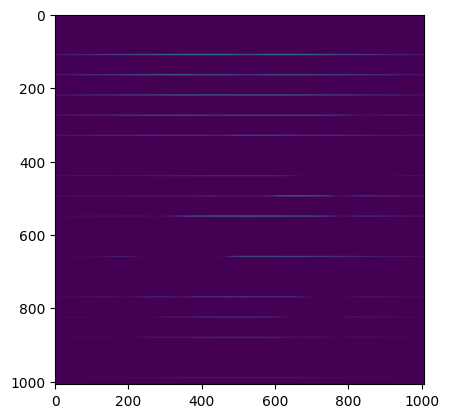

(1008, 44100)


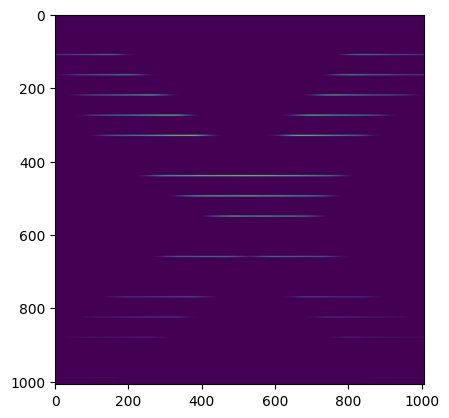

(1008, 44100)
SSIM score: 0.917047977496896


In [299]:
import cv2
'''
                                            Passing 4 and 5 through gaussian
'''

inputs = ['thenumber4','thenumber5']

#note to assign for inputs
fundamental_note = 110
#center of y-direction filter
mu = fundamental_note * 1
#y-direction filter sd
sigma = 400
#track fades in and out
fade_inout = 250
#smear x
smear_x = 20
#smear y
smear_y = 1
#x and y smoothing
smooth_xy = 0
#duration of track
duration = 1

##NOISE APPLIED TO OUTPUT
#Perlin noise constants for x and y
pnoisex = 24
pnoisey = 24
#Adds static fuzz to spectrogram
fuzz = 1
#Waters down perlin noise
dilution = 20

##NOISE OVERLAID
scale = 0 # Set 0 to disable
pnoisex2 = 2
pnoisey2 = 24
fuzz2 = 0
dilution2 = 20



for i in inputs:

    upscale(f'{i}')

    #Gaussian Filter
    im2array = cv2.imread(f'{i}.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
    filtered = gaussianfilter(im2array, sigma, mu, fade_inout)
    curr = filtered

    #Harmonics etc
    harmonic = freq_selection(curr, fundamental_note)
    curr = harmonic

    #y-axis gaussian smear
    y_gaussian = gaussian1d(curr, smear_y, 0)
    curr = y_gaussian
    curr = (curr - curr.min()) / (curr.max() - curr.min()) * 255

    #x-axis gaussian smear
    x_gaussian = gaussian1d(curr, smear_x, 1)
    curr = x_gaussian
    curr = (curr - curr.min()) / (curr.max() - curr.min()) * 255

    #smoothing (2-D gaussian)
    smoothed = gaussian2d(curr, smooth_xy)
    curr = smoothed
    curr = (curr - curr.min()) / (curr.max() - curr.min()) * 255

    #perlin-noise
    perlin = perlin_2d(curr, pnoisex, pnoisey, fuzz, dilution)
    curr = perlin
    curr = (curr - curr.min()) / (curr.max() - curr.min()) * 255

    #noise overlay
    overlay = perlin_2d_filter(curr, scale, pnoisex2, pnoisey2, fuzz2, dilution2)
    curr = curr + overlay

    plt.imshow(curr)
    plt.show()

    #convert to wav file
    convert_to_wav(curr, f'{i}-out.wav', duration)

    #save image for comparison
    Image.fromarray(curr).convert('RGB').save(f'{i}-out.png')

#compare images
imageA = cv2.imread(f'{inputs[0]}-out.png')
imageB = cv2.imread(f'{inputs[1]}-out.png')

ssim_score = calculate_ssim(imageA, imageB)
print(f"SSIM score: {ssim_score}")
    
